## Using the Yelp API to Investigate the Restaurant Scene in Los Angeles County

In [11]:
import requests
import pandas as pd
from pandas import json_normalize
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler , Normalizer, MinMaxScaler, OneHotEncoder, RobustScaler, MaxAbsScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
api_key = '3F_lCJ4vg0r62oOgRHcDXSxsqjj2mVGGu-kgdXiBPTwHynizbHrphlZaZ0pYEuxNtcZw86gdnBVr7J0wVuZumktYiTZzhFEWJ-rlsS4anGkqcTnSL_tJ9NYRyTxIYHYx'
headers = {'Authorization': 'Bearer %s' % api_key}

### Collect and clean data


Create dataset for > 1000 restaurants in LA County 
API Link: https://api.yelp.com/v3/businesses/search

In [32]:
locations = ['Los Angeles', 'Palmdale', 'Lancaster', 'Santa Clarita', 'Long Beach', 'Glendale', 'Pasadena', 'Pomona',
             'Torrance', 'Malibu', 'Hawaiian Gardens', 'Gardena', 'Hermosa Beach', 'Maywoord', 'Cudahy', 'Artesia', 
             'Hidden Hills', 'West Hollywood', 'Lomita', 'Bradbury', 'Lawndale', 'San Gabriel', 'El Segundo', 'Culver City',
             'Huntington Park', 'Lawndale', 'Signal Hill', 'Downey']
df_restaurants = pd.DataFrame()
business_search_url = 'https://api.yelp.com/v3/businesses/search'
for loc in locations:
  param={'term':'restaurants','location': loc, 'limit': 50}
  response=requests.get(business_search_url, headers=headers, params=param)
  temp = json_normalize(response.json()['businesses'])
  df_restaurants = pd.concat([df_restaurants, temp])

In [33]:
df = df_restaurants

In [34]:
df.to_csv('restaurants.csv')

In [35]:
#import file restaurants.csv 
df_restaurants = pd.read_csv("restaurants.csv")
df_restaurants = df_restaurants[df_restaurants.columns[1:]]
df_restaurants = df_restaurants[['id', 'name','review_count','categories','rating', 'price','display_phone','coordinates.latitude','coordinates.longitude', 'location.address1','location.address2','location.city','location.zip_code','location.state','location.country']]
df_restaurants.head()

,id,name,review_count,categories,rating,price,display_phone,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.city,location.zip_code,location.state,location.country
0,z0zaCVA-p_5xTsyUZrmR0g,Republique,5658,"[{'alias': 'french', 'title': 'French'}, {'ali...",4.0,$$,(310) 362-6115,34.064130,-118.343820,624 S La Brea Ave,NaN,Los Angeles,90036,CA,US
1,1mb6fp_JRp4Y68GStJsGIQ,The Rooftop at The Wayfarer Downtown LA,119,"[{'alias': 'newamerican', 'title': 'American (...",4.0,$$$,(213) 285-4391,34.047120,-118.260730,813 Flower St,NaN,Los Angeles,90017,CA,US
2,vs8USEc1A480H8MnmFKs5A,Chadolpoong,352,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.5,$$,(213) 263-2004,34.063090,-118.297540,3470 W 6th St,Ste 3,Los Angeles,90020,CA,US
3,MlmcOkwaNnxl3Zuk6HsPCQ,Slurpin' Ramen Bar - Los Angeles,4640,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...",4.5,$$,(213) 388-8607,34.057361,-118.306770,3500 W 8th St,NaN,Los Angeles,90005,CA,US
4,6i7KnRylm4bhPIApDFSVCg,Dave's Hot Chicken,3439,"[{'alias': 'chickenshop', 'title': 'Chicken Sh...",4.5,$$,(323) 536-9711,34.088068,-118.308962,970 N Western Ave,NaN,Los Angeles,90029,CA,US


Reviews dataset contains: review_id, user_id, business_id, 
review, ratings, date

API Link: https://api.yelp.com/v3/businesses/{id}/reviews


In [17]:
df_reviews = pd.DataFrame()
for id in df_restaurants['id']:
  url = 'https://api.yelp.com/v3/businesses/%s/reviews' % str(id)
  response=requests.get(url, headers=headers)
  if (response.status_code == 200):
    temp = json_normalize(response.json()['reviews'])
    temp['business_id'] = id
    df_reviews = pd.concat([df_reviews, temp])

In [18]:
# df_reviews = pd.read_csv("reviews.csv")
df_reviews.head()

,id,url,text,rating,time_created,user.id,user.profile_url,user.image_url,user.name,business_id
0,DjJs3ORrnrOQO662zu5TKQ,https://www.yelp.com/biz/republique-los-angele...,The five stars is for doing business during Co...,5,2021-03-12 22:32:00,UPwwlocjI7pWOxbldurUKA,https://www.yelp.com/user_details?userid=UPwwl...,https://s3-media2.fl.yelpcdn.com/photo/8Ei6j_9...,Edita D.,z0zaCVA-p_5xTsyUZrmR0g
1,2MnCCJ2T1r7PgGkbkAlrZg,https://www.yelp.com/biz/republique-los-angele...,I went last weekend with my girlfriend for Bru...,5,2021-03-11 07:55:19,TzWy8LKNrAt8wn8E_tVe7A,https://www.yelp.com/user_details?userid=TzWy8...,https://s3-media1.fl.yelpcdn.com/photo/Mq5bDhj...,Giulio G.,z0zaCVA-p_5xTsyUZrmR0g
2,dCgU1wRLKAAiGWbC5TP5Hg,https://www.yelp.com/biz/republique-los-angele...,"Prompt, professional service. We ordered just ...",5,2021-03-15 10:18:09,KYSYHhfPGcKaCEMOv10ZYA,https://www.yelp.com/user_details?userid=KYSYH...,https://s3-media3.fl.yelpcdn.com/photo/kVplIQh...,Sarah L.,z0zaCVA-p_5xTsyUZrmR0g
0,PHky-3T2yeoB5RIs_4yfLA,https://www.yelp.com/biz/the-rooftop-at-the-wa...,My friend and I came here for an evening in DT...,4,2021-03-03 14:06:46,J2IxIf59M8vLpbeA2I8kiw,https://www.yelp.com/user_details?userid=J2IxI...,https://s3-media1.fl.yelpcdn.com/photo/2qnARK1...,Nani S.,1mb6fp_JRp4Y68GStJsGIQ
1,iKnUpC4yZfFnAfW-xcvIBQ,https://www.yelp.com/biz/the-rooftop-at-the-wa...,This was the first time we had been out since ...,5,2021-03-02 20:15:11,vhdOpmlXtNDnLkBNRmdDVw,https://www.yelp.com/user_details?userid=vhdOp...,https://s3-media1.fl.yelpcdn.com/photo/fC7kTWu...,KC O.,1mb6fp_JRp4Y68GStJsGIQ


### Part 1: Overview of restaurants landscape in Los Angeles County 


In [19]:
df_restaurants["location.city"].value_counts()

Los Angeles        90
Long Beach         88
Gardena            62
Pasadena           51
Torrance           50
                   ..
Chino               1
East Petersburg     1
Montclair           1
Ontario             1
Lancaster PA        1
Name: location.city, Length: 86, dtype: int64

Text(0, 0.5, 'Number of Restaurants With Reviews')

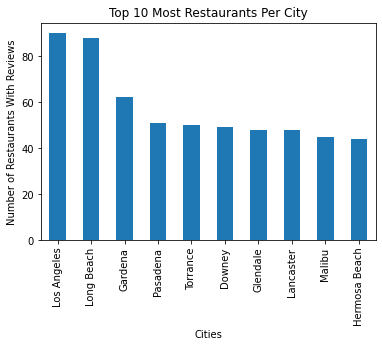

In [20]:
#number of restaurants per city, 10 most popular
city = df_restaurants["location.city"].value_counts()
top10 = city.head(10)
top10.plot.bar()
plt.title("Top 10 Most Restaurants Per City")
plt.xlabel("Cities")
plt.ylabel("Number of Restaurants With Reviews")

Text(0, 0.5, 'Average Rating')

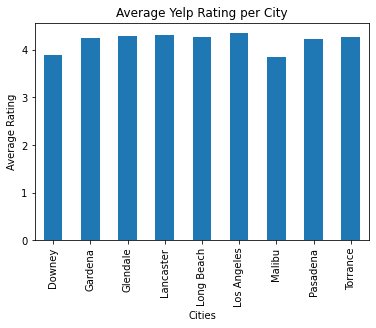

In [21]:
#average yelp rating in each city
df_top10 = df_restaurants[(df_restaurants["location.city"] == "Los Angeles") | (df_restaurants["location.city"] == "Long Beach") | (df_restaurants["location.city"] == "Gardena") |
(df_restaurants["location.city"] == "Pasadena") | (df_restaurants["location.city"] == "Glendale") | (df_restaurants["location.city"] == "Downey") | (df_restaurants["location.city"] == "Lancaster") |
(df_restaurants["location.city"] == "Torrance") | (df_restaurants["location.city"] == "Malibu") | (df_restaurants["location.city"] == "hermosa Beach")]
(df_top10.groupby("location.city")["rating"].mean().plot.bar())
plt.title("Average Yelp Rating per City")
plt.xlabel("Cities")
plt.ylabel("Average Rating")

In [22]:
df_top10.groupby("location.city")["rating"].mean()

location.city
Downey         3.887755
Gardena        4.250000
Glendale       4.281250
Lancaster      4.312500
Long Beach     4.272727
Los Angeles    4.355556
Malibu         3.844444
Pasadena       4.235294
Torrance       4.280000
Name: rating, dtype: float64

In [37]:
#average yelp rating per type of restaurant
df_restaurants["type"] = df_restaurants["categories"]
df_restaurants["type"] = df_restaurants["type"].astype(str)
df_restaurants["type"] = df_restaurants["type"].str.replace('[', '')
df_restaurants["type"] = df_restaurants["type"].str.replace(']', '')
df_restaurants["type"] = df_restaurants["type"].str.replace('{', '')
df_restaurants["type"] = df_restaurants["type"].str.replace('}', '')
df_restaurants["type"] = df_restaurants["type"].str.replace('\'', '')
df_restaurants["type"] = df_restaurants["type"].str.replace("alias:", '')
df_restaurants["type"] = df_restaurants["type"].str.replace("title:", '')
df_restaurants["type"] = df_restaurants["type"].str.split(",")


for i in range(0,len(df_restaurants["type"])-1):
  df_restaurants["type"][i] = df_restaurants["type"][i][0]

df_restaurants

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,id,name,review_count,categories,rating,price,display_phone,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.city,location.zip_code,location.state,location.country,type
0,z0zaCVA-p_5xTsyUZrmR0g,Republique,5658,"[{'alias': 'french', 'title': 'French'}, {'ali...",4.0,$$,(310) 362-6115,34.064130,-118.343820,624 S La Brea Ave,NaN,Los Angeles,90036,CA,US,french
1,1mb6fp_JRp4Y68GStJsGIQ,The Rooftop at The Wayfarer Downtown LA,119,"[{'alias': 'newamerican', 'title': 'American (...",4.0,$$$,(213) 285-4391,34.047120,-118.260730,813 Flower St,NaN,Los Angeles,90017,CA,US,newamerican
2,vs8USEc1A480H8MnmFKs5A,Chadolpoong,352,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.5,$$,(213) 263-2004,34.063090,-118.297540,3470 W 6th St,Ste 3,Los Angeles,90020,CA,US,korean
3,MlmcOkwaNnxl3Zuk6HsPCQ,Slurpin' Ramen Bar - Los Angeles,4640,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...",4.5,$$,(213) 388-8607,34.057361,-118.306770,3500 W 8th St,NaN,Los Angeles,90005,CA,US,ramen
4,6i7KnRylm4bhPIApDFSVCg,Dave's Hot Chicken,3439,"[{'alias': 'chickenshop', 'title': 'Chicken Sh...",4.5,$$,(323) 536-9711,34.088068,-118.308962,970 N Western Ave,NaN,Los Angeles,90029,CA,US,chickenshop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,bNXz4aTqJgzIh71MWgELog,Pop's Cafe,681,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,$,(562) 927-0096,33.954906,-118.133045,7840 Florence Ave,NaN,Downey,90240,CA,US,breakfast_brunch
1356,WXNtIcZUfracs6uZ-r9wog,Sizzling Thai Kitchen,452,"[{'alias': 'thai', 'title': 'Thai'}]",4.0,$,(562) 923-2294,33.931528,-118.137690,8330 Stewart And Gray Rd,NaN,Downey,90241,CA,US,thai
1357,AwHxBOjMUmgNimkYulajPw,Paper Pizza,66,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.0,NaN,(562) 414-0009,33.953973,-118.113456,9500 Lakewood Blvd,NaN,Downey,90240,CA,US,pizza
1358,vR92Eu4juUA0bYiPQf1CCA,Noodles & Company,188,"[{'alias': 'noodles', 'title': 'Noodles'}, {'a...",3.0,$,(562) 803-1330,33.922566,-118.130705,8900 Apollo Way,NaN,Downey,90242,CA,US,noodles


Text(0, 0.5, 'Number of Restaurants in LA')

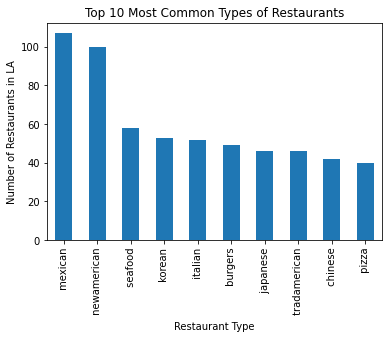

In [38]:
types = df_restaurants["type"].value_counts()
top10 = types.head(10)
top10.plot.bar()
plt.title("Top 10 Most Common Types of Restaurants")
plt.xlabel("Restaurant Type")
plt.ylabel("Number of Restaurants in LA")

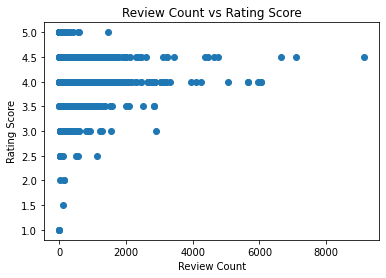

In [39]:
#review counts vs rating
plt.scatter(df_restaurants['review_count'],df_restaurants['rating'])
plt.title("Review Count vs Rating Score")
plt.xlabel("Review Count")
plt.ylabel("Rating Score")
plt.show()

In [40]:
from altair import *

Chart(df_restaurants).mark_circle().encode(
    x="review_count",
    y="rating",
    column = "price"
)

alt.Chart(...)

In [41]:
df_restaurants.groupby("price")["rating"].mean()

price
$       4.093333
$$      4.131679
$$$     4.059322
$$$$    4.250000
￥       4.500000
Name: rating, dtype: float64

### Part 2: Fitting a Model to Predict a Restaurant's Rating

In [42]:
df_restaurants_new = df_restaurants[['review_count', 'price', 'location.city', 'location.zip_code', 'type', 'rating']].copy()
df_restaurants_new = df_restaurants_new.dropna()
df_restaurants_new['location.zip_code'] = df_restaurants_new['location.zip_code'].astype(str)
df_restaurants_new['location.city'] = df_restaurants_new['location.city'].astype(str)
df_restaurants_new['price'] = df_restaurants_new['price'].astype(str)
df_restaurants_new['rating'] = df_restaurants_new['rating'].astype(int)
df_restaurants_new['type'] = df_restaurants_new['type'].astype(str)
df_restaurants_new['review_count'] = df_restaurants_new['review_count'].astype(int)
df_restaurants_new.loc[1359,'type'] = 'cuban'
df_restaurants_new

,review_count,price,location.city,location.zip_code,type,rating
0,5658,$$,Los Angeles,90036,french,4
1,119,$$$,Los Angeles,90017,newamerican,4
2,352,$$,Los Angeles,90020,korean,4
3,4640,$$,Los Angeles,90005,ramen,4
4,3439,$$,Los Angeles,90029,chickenshop,4
...,...,...,...,...,...,...
1354,502,$$,Downey,90240,breakfast_brunch,3
1355,681,$,Downey,90240,breakfast_brunch,4
1356,452,$,Downey,90241,thai,4
1358,188,$,Downey,90242,noodles,3


In [43]:
def kmodels(scaler, distance, x_train, y_train, x_test, y_test):
  ct = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'), list(x_train.columns)[1:]),
    remainder = "passthrough"
  )
  ct2 = make_column_transformer(
    (RobustScaler(), ['review_count']),
    (OneHotEncoder(handle_unknown='ignore'), list(x_train.columns)[1:]),
    remainder = "passthrough"
  )
  ct3 = make_column_transformer(
    (MaxAbsScaler(), ['review_count']),
    (OneHotEncoder(handle_unknown = 'ignore'), list(x_train.columns)[1:]),
    remainder = "passthrough"
  )
  if scaler == 'standard':
    pipeline = make_pipeline(ct, StandardScaler(with_mean=False), 
                             KNeighborsRegressor(n_neighbors=20, metric=distance))
  elif scaler == 'normalized':
    pipeline = make_pipeline(ct, Normalizer(), 
                             KNeighborsRegressor(n_neighbors=20, metric=distance))
  elif scaler == 'maxabs':
    pipeline = make_pipeline(ct3, MaxAbsScaler(), 
                             KNeighborsRegressor(n_neighbors=20, metric=distance))
  elif scaler == 'robust':
    pipeline = make_pipeline(ct2, RobustScaler(with_centering=False), 
                             KNeighborsRegressor(n_neighbors=20, metric=distance))
  pipeline.fit(X=x_train, y=y_train)
  predict = pipeline.predict(X=x_test)
  rmse = np.sqrt(mean_squared_error(y_test, predict))
  pipescore = pipeline.score(x_test, y_test)

  print('rmse for {}, {}: {}'.format(scaler, distance, rmse))
  print('model accuracy score for {}, {}: {}\n'.format(scaler, distance, pipescore))
  return pipescore

In [44]:
#predict restaurants rating based on it's features
df_train, df_test = train_test_split(df_restaurants_new, test_size=0.2)

x_train1 = df_train[['review_count', 'price', 'location.city', 'location.zip_code', 'type']]
x_test1 = df_test[['review_count', 'price', 'location.city', 'location.zip_code', 'type']]
x_train2 = df_train[['review_count', 'price', 'location.city', 'type']]
x_test2 = df_test[['review_count', 'price', 'location.city', 'type']]
x_train3 = df_train[['review_count', 'price', 'type']]
x_test3 = df_test[['review_count', 'price', 'type']]
x_train4 = df_train[['review_count', 'price', 'location.city']]
x_test4 = df_test[['review_count', 'price','location.city']]
x_train5 = df_train[['review_count','location.city']]
x_test5 = df_test[['review_count','location.city']]
x_train6 = df_train[['review_count', 'price',]]
x_test6 = df_test[['review_count', 'price',]]
list_x_test = [x_test1,x_test2,x_test3,x_test4,x_test5,x_test6]
list_x_train = [x_train1, x_train2, x_train3, x_train4, x_train5, x_train6]
y_train = df_train['rating']
y_test = df_test['rating']

In [45]:
model_types = ['standard', 'normalized', 'maxabs', 'robust']
distance_types = ['euclidean', 'manhattan', 'minkowski']
df_model = pd.DataFrame()
for i in range(len(list_x_train)):
  print("___________________________________________________________")
  print("train model based on " + str(list(list_x_train[i].columns)))
  df_model.loc[i,'features'] = str(list(list_x_train[i].columns))
  print("___________________________________________________________")
  max_score = []
  for model in model_types:
    for distance in distance_types:
      max_score.append(kmodels(model, distance, list_x_train[i], y_train, list_x_test[i] , y_test))
  df_model.loc[i,'max score'] = np.max(max_score)

___________________________________________________________
train model based on ['review_count', 'price', 'location.city', 'location.zip_code', 'type']
___________________________________________________________
rmse for standard, euclidean: 0.3781380331215352
model accuracy score for standard, euclidean: 0.08529788264600013

rmse for standard, manhattan: 0.3670593387172364
model accuracy score for standard, manhattan: 0.13811064212565705

rmse for standard, minkowski: 0.3781380331215352
model accuracy score for standard, minkowski: 0.08529788264600013

rmse for normalized, euclidean: 0.3760875702082113
model accuracy score for normalized, euclidean: 0.09519097702740065

rmse for normalized, manhattan: 0.37599480451630685
model accuracy score for normalized, manhattan: 0.09563728203708788

rmse for normalized, minkowski: 0.3760875702082113
model accuracy score for normalized, minkowski: 0.09519097702740065

rmse for maxabs, euclidean: 0.375143383440965
model accuracy score for maxabs,

Text(0.5, 1.0, 'Maximum Accuracy Score for Different Combinations of Features')

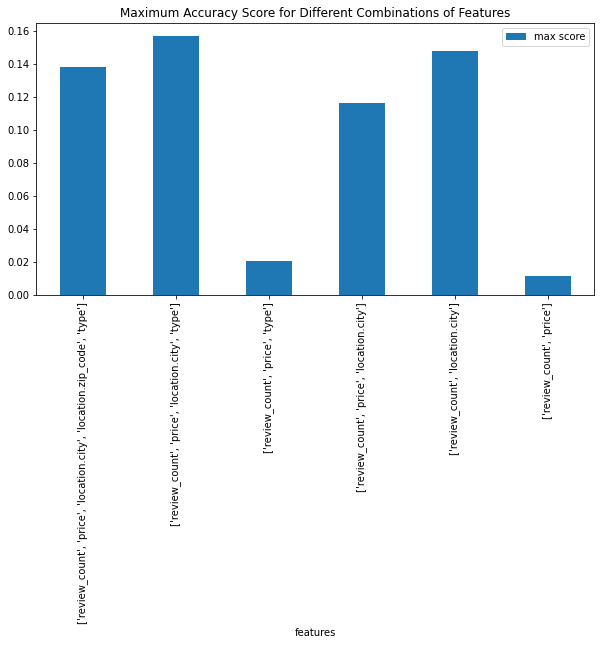

In [46]:
df_model.plot.bar(x='features',y='max score', figsize=(10, 5))
plt.title("Maximum Accuracy Score for Different Combinations of Features")

### Part 3: Advance the restaurant recommendation system based on user’s preferences 

In [47]:
def clean_data(data):
  data = data.lower()
  data = ''.join([char for char in data if char not in string.punctuation])
  data = ' '.join([word for word in data.split() if word not in stopwords.words('english')])
  return data

def search_input(search, top_n):
  search_row = pd.DataFrame({'business_id': 'None', 'user.id': 'None', 'rating': 'None', 'text': search}, index=[0])
  search = pd.concat([search_row, yelp_review])
  vec = TfidfVectorizer(norm=None)
  vec.fit(yelp_review['text'].fillna("None"))
  tf_idf_sparse = vec.transform(search['text'])
  similarity = cosine_similarity(tf_idf_sparse)[0]
  return search.iloc[similarity.argsort()[-(top_n+1):][::-1][1:]]

In [53]:
df_reviews = df_reviews.rename(columns ={'id' : 'review_id'})
df_reviews.head()

,review_id,url,text,rating,time_created,user.id,user.profile_url,user.image_url,user.name,business_id
0,DjJs3ORrnrOQO662zu5TKQ,https://www.yelp.com/biz/republique-los-angele...,The five stars is for doing business during Co...,5,2021-03-12 22:32:00,UPwwlocjI7pWOxbldurUKA,https://www.yelp.com/user_details?userid=UPwwl...,https://s3-media2.fl.yelpcdn.com/photo/8Ei6j_9...,Edita D.,z0zaCVA-p_5xTsyUZrmR0g
1,2MnCCJ2T1r7PgGkbkAlrZg,https://www.yelp.com/biz/republique-los-angele...,I went last weekend with my girlfriend for Bru...,5,2021-03-11 07:55:19,TzWy8LKNrAt8wn8E_tVe7A,https://www.yelp.com/user_details?userid=TzWy8...,https://s3-media1.fl.yelpcdn.com/photo/Mq5bDhj...,Giulio G.,z0zaCVA-p_5xTsyUZrmR0g
2,dCgU1wRLKAAiGWbC5TP5Hg,https://www.yelp.com/biz/republique-los-angele...,"Prompt, professional service. We ordered just ...",5,2021-03-15 10:18:09,KYSYHhfPGcKaCEMOv10ZYA,https://www.yelp.com/user_details?userid=KYSYH...,https://s3-media3.fl.yelpcdn.com/photo/kVplIQh...,Sarah L.,z0zaCVA-p_5xTsyUZrmR0g
0,PHky-3T2yeoB5RIs_4yfLA,https://www.yelp.com/biz/the-rooftop-at-the-wa...,My friend and I came here for an evening in DT...,4,2021-03-03 14:06:46,J2IxIf59M8vLpbeA2I8kiw,https://www.yelp.com/user_details?userid=J2IxI...,https://s3-media1.fl.yelpcdn.com/photo/2qnARK1...,Nani S.,1mb6fp_JRp4Y68GStJsGIQ
1,iKnUpC4yZfFnAfW-xcvIBQ,https://www.yelp.com/biz/the-rooftop-at-the-wa...,This was the first time we had been out since ...,5,2021-03-02 20:15:11,vhdOpmlXtNDnLkBNRmdDVw,https://www.yelp.com/user_details?userid=vhdOp...,https://s3-media1.fl.yelpcdn.com/photo/fC7kTWu...,KC O.,1mb6fp_JRp4Y68GStJsGIQ


In [54]:
# df_reviews = pd.read_csv("reviews.csv")
# df_reviews = df_reviews[df_reviews.columns[1:]]
df_reviews = df_reviews[['review_id','text','rating','time_created','user.id','business_id']]
yelp_review = df_reviews[['business_id','user.id', 'rating', 'text']]
yelp_review.head()

,business_id,user.id,rating,text
0,z0zaCVA-p_5xTsyUZrmR0g,UPwwlocjI7pWOxbldurUKA,5,The five stars is for doing business during Co...
1,z0zaCVA-p_5xTsyUZrmR0g,TzWy8LKNrAt8wn8E_tVe7A,5,I went last weekend with my girlfriend for Bru...
2,z0zaCVA-p_5xTsyUZrmR0g,KYSYHhfPGcKaCEMOv10ZYA,5,"Prompt, professional service. We ordered just ..."
0,1mb6fp_JRp4Y68GStJsGIQ,J2IxIf59M8vLpbeA2I8kiw,4,My friend and I came here for an evening in DT...
1,1mb6fp_JRp4Y68GStJsGIQ,vhdOpmlXtNDnLkBNRmdDVw,5,This was the first time we had been out since ...


In [55]:
yelp_review.loc[0,'text']

0    The five stars is for doing business during Co...
0    My friend and I came here for an evening in DT...
0    Stopped by after dropping off family at LAX po...
0    LOVED this ramen! Quick delivery during COVID ...
0    The fact that I haven't left a review for Dave...
                           ...                        
0    Such a quaint little restaurant! I'm sad to sa...
0    *** hope this quaint little Thai place with so...
0    I have been following this place and it's sist...
0    We ordered from Doordash and the food was amaz...
0    Ordered delivery once again and I was not disa...
Name: text, Length: 1360, dtype: object

In [56]:
yelp_review['text'] = yelp_review['text'].apply(clean_data)
yelp_review = yelp_review.drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
yelp_review.loc[0,'text']

0    five stars business covid thanks risking lives...
0    friend came evening dtla drinks snacks rooftop...
0    stopped dropping family lax postcovid sat outs...
0    loved ramen quick delivery covid via doordash ...
0    fact havent left review daves dam shame live l...
                           ...                        
0    quaint little restaurant im sad say havent abl...
0    hope quaint little thai place awesome lunch sp...
0    following place sister store lock key ig long ...
0    ordered doordash food amazing spaghetti meatba...
0    ordered delivery disappointed used dine looong...
Name: text, Length: 1228, dtype: object

In [58]:
# search for a place
search = 'i want mexican food'
recommend_place = search_input(search, 5)
print(recommend_place)
df_restaurants[np.isin(df_restaurants, recommend_place['business_id']).any(axis=1)]

              business_id  ...                                               text
0  2qmIiaa93nIgrGkY8As8Zw  ...  one want say love place want continue like tac...
0  4x2nIXBpOBSiJLClgdbGkA  ...  great tasking authentic mexican food favorite ...
1  f-InW8yKlSM9YvtTOSQ72g  ...  food fire price reasonable recommend place hom...
1  QX6arLOBlSxJ5lSdNuwXzg  ...  finally bf finally found truly authentic amazi...
0  sJFBqSAk0Hyz5z3xvMRz3Q  ...  ive tried many gourmet mexican restaurants pas...

[5 rows x 4 columns]


,id,name,review_count,categories,rating,price,display_phone,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.city,location.zip_code,location.state,location.country,type
503,QX6arLOBlSxJ5lSdNuwXzg,Delicias El Brother,189,"[{'alias': 'juicebars', 'title': 'Juice Bars &...",4.5,$,(562) 316-5242,33.831245,-118.076935,11962 Carson St,NaN,Hawaiian Gardens,90716,CA,US,juicebars
660,4x2nIXBpOBSiJLClgdbGkA,Ramirez Restaurant,8,"[{'alias': 'newamerican', 'title': 'American (...",4.5,$,(323) 771-8014,33.987290,-118.189730,4308 Slauson Ave,NaN,Maywood,90270,CA,US,newamerican
673,f-InW8yKlSM9YvtTOSQ72g,Tacos El Compa Est. 1995,4,"[{'alias': 'mexican', 'title': 'Mexican'}]",5.0,NaN,(323) 582-9449,33.988266,-118.192400,4063 Slauson Ave,NaN,Maywood,90270,CA,US,mexican
1067,sJFBqSAk0Hyz5z3xvMRz3Q,SAUSAL,755,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.0,$$,(310) 322-2721,33.918153,-118.416095,219 Main St,NaN,El Segundo,90245,CA,US,mexican
1183,2qmIiaa93nIgrGkY8As8Zw,El Pariente,17,"[{'alias': 'mexican', 'title': 'Mexican'}, {'a...",4.0,$,(323) 537-8030,33.972210,-118.224930,7400 Pacific Blvd,NaN,Huntington Park,90255,CA,US,mexican


In [59]:
# search for a place
search = "i want to have dinner with a beautiful view"
recommend_place = search_input(search, 5)
print(recommend_place)
df_restaurants[np.isin(df_restaurants, recommend_place['business_id']).any(axis=1)]

              business_id  ...                                               text
1  A3ae4lhHgycID4XlLe97bw  ...  place beautiful romantic service wonderful foo...
0  22I6xDcJySjVb65sS1xvIw  ...  went dinner new years eve loved sitting piano ...
0  09TxR2XvzzJl7GaY-E2-lw  ...  zanes beautiful restaurant located great peopl...
0  2qmIiaa93nIgrGkY8As8Zw  ...  one want say love place want continue like tac...
0  eNocVcwXHXiKyfz7vmt_Fg  ...  definitely hidden gem pandemic view parking lo...

[5 rows x 4 columns]


,id,name,review_count,categories,rating,price,display_phone,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.city,location.zip_code,location.state,location.country,type
115,A3ae4lhHgycID4XlLe97bw,Harvest Seasonal Grill & Wine Bar - Lancaster,114,"[{'alias': 'newamerican', 'title': 'American (...",4.0,$$,(717) 740-5282,40.067384,-76.314476,1573 Fruitville Pike,NaN,Lancaster,17601,PA,US,newamerican
135,22I6xDcJySjVb65sS1xvIw,Josephine's,6,"[{'alias': 'french', 'title': 'French'}, {'ali...",4.5,$$$,(717) 299-7090,40.038515,-76.307022,50 W Grant St,NaN,Lancaster,17603,PA,US,french
379,eNocVcwXHXiKyfz7vmt_Fg,Compadres Cantina,530,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",4.5,$$,(909) 458-1149,34.032215,-117.652538,2250 S Euclid Ave,Ste E,Ontario,91762,CA,US,bars
616,09TxR2XvzzJl7GaY-E2-lw,Zane's,535,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...",4.0,$$$,(310) 374-7488,33.862103,-118.399788,1150 Hermosa Ave,NaN,Hermosa Beach,90254,CA,US,steak
1183,2qmIiaa93nIgrGkY8As8Zw,El Pariente,17,"[{'alias': 'mexican', 'title': 'Mexican'}, {'a...",4.0,$,(323) 537-8030,33.972210,-118.224930,7400 Pacific Blvd,NaN,Huntington Park,90255,CA,US,mexican
